### T-Period Consumption-Saving Model
Solves and simulates a simple $T$-period consumption-saving model without any shocks:

$$
\begin{align}
V_t(a_t) &= \max_{c_t > 0} \frac{c_t^{1-\rho}}{1-\rho} + \beta \cdot V_{t+1}(a_{t+1}) \\

\text{s.t.}\\
 \quad a_{t+1} &= (1 + r)(a_t - c_t + y_t), \quad a_0 = 0 \\
 
a_t &\geq 0, \quad \forall , t
\end{align}
$$


###  Model Parameter Settings

| **Parameter** | **Value**                          | **Description**                           |
|---------------|------------------------------------|-------------------------------------------|
| `T`           | 50                                 | Number of periods                         |
| `β` (`beta`)  | 0.98                               | Discount factor                           |
| `ρ` (`rho`)   | 2.0                                | Relative risk aversion (CRRA)             |
| `y`           | 30,000                             | Constant income per period                |
| `r`           | 0.02                               | Interest rate                             |
| `a_max`       | 150,000                            | Maximum assets in the grid                |
| `Na`          | 1000                               | Number of asset grid points               |
| `simN`        | 5000                               | Number of simulated agents                |
| `a_grid`      | `nonlinspace(0.0, a_max, Na, 5.0)` | Nonlinear asset grid (curved toward 0)    |

### Setup

In [2]:
using Random, Optim, LinearAlgebra, Interpolations
using Plots, Statistics, ProgressMeter

### Model

In [3]:

# --------------------------
# Helper Functions
# --------------------------
# Create a nonlinear spaced grid (similar to Python's nonlinspace)
function nonlinspace(start::Float64, stop::Float64, num::Int, curvature::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curvature
    return start .+ (stop - start) .* curved_vals
end

# CRRA Utility Function
@inline function util(c::Float64, rho::Float64)
    return (c^(1 - rho)) / (1 - rho)
end

# --------------------------
# Model Definition
# --------------------------
mutable struct ConSavModel
    # Model parameters
    T::Int               # Number of periods
    beta::Float64        # Discount factor
    rho::Float64         # Risk aversion coefficient
    y::Float64           # Income level (assumed constant over time)
    r::Float64           # Interest rate
    a_max::Float64       # Maximum asset level in grid
    Na::Int              # Number of grid points
    simT::Int            # Simulation time horizon
    simN::Int            # Number of simulated agents

    # Grids and time series
    a_grid::Vector{Float64}  # Asset grid
    yt::Vector{Float64}      # Income over time

    # Matrices for solution and simulation
    sol_c::Matrix{Float64}   # Optimal consumption (time × assets)
    sol_V::Matrix{Float64}   # Value function (time × assets)
    sim_c::Matrix{Float64}   # Simulated consumption paths (agents × time)
    sim_a::Matrix{Float64}   # Simulated asset paths (agents × time)
    sim_a_init::Vector{Float64}  # Initial assets for simulation

    # Constructor with default parameters
    function ConSavModel(; T::Int=50, beta::Float64=0.98, rho::Float64=2.0, y::Float64=30000.0, 
                         r::Float64=0.02, a_max::Float64=150000.0, Na::Int=1000, simN::Int=5000)
        a_grid = nonlinspace(0.0, a_max, Na, 5.0)  # Nonlinear asset grid
        # Income over time (constant for simplicity)
        yt = fill(y, T)

        sol_c = Matrix{Float64}(undef, T, Na)
        sol_V = Matrix{Float64}(undef, T, Na)
        sim_c = Matrix{Float64}(undef, simN, T)
        sim_a = Matrix{Float64}(undef, simN, T)
        sim_a_init = zeros(simN)

        # Here simT is set equal to T
        return new(T, beta, rho, y, r, a_max, Na, T, simN, a_grid, yt, sol_c, sol_V, sim_c, sim_a, sim_a_init)
    end
end

# --------------------------
# Model Solver
# --------------------------
# Calculate the value of a given consumption choice
function value_of_choice(model::ConSavModel, cons::Float64, assets::Float64, t::Int)
    u = util(cons, model.rho)
    # Terminal period: no future utility
    if t == model.T
        return u
    else
        # Next period's assets given current consumption
        a_next = (1 + model.r) * (assets + model.yt[t] - cons)
        # Interpolate the next period's value function
        itp = LinearInterpolation(model.a_grid, model.sol_V[t+1, :], extrapolation_bc=Line())
        V_next = itp(a_next)
        return u + model.beta * V_next
    end
end

# Solve the model via backward induction
function solve_model!(model::ConSavModel)
    T, Na = model.T, model.Na

    # Last period: consume all resources
    t = T
    model.sol_c[t, :] .= model.a_grid .+ model.yt[t]
    model.sol_V[t, :] .= util.(model.sol_c[t, :], model.rho)

    # Backward induction from period T-1 to 1
    @showprogress for t in (T-1):-1:1
        for ia in 1:Na
            assets = model.a_grid[ia]
            # Define the objective function to be maximized
            obj = c -> -value_of_choice(model, c[1], assets, t)
            lb = 1e-6                      # Lower bound for consumption (avoid zero)
            ub = assets + model.yt[t]        # Upper bound: available resources
            c_init = [lb + 0.5*(ub - lb)]      # Initial guess for optimization

            # In degenerate cases, assign the resource level directly
            if lb >= ub
                model.sol_c[t, ia] = ub
                model.sol_V[t, ia] = -obj([ub])
            else
                result = optimize(obj, lb, ub, GoldenSection())
                model.sol_c[t, ia] = result.minimizer[1]
                model.sol_V[t, ia] = -result.minimum
            end
        end
    end
end

# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions
function simulate!(model::ConSavModel)
    itps = [LinearInterpolation(model.a_grid, model.sol_c[t, :], extrapolation_bc=Line()) for t in 1:model.T]

    @inbounds for i in 1:model.simN
        model.sim_a[i, 1] = model.sim_a_init[i]

        for t in 1:model.simT
            if t <= model.T
                model.sim_c[i, t] = itps[t](model.sim_a[i, t])
                if t < model.simT
                    model.sim_a[i, t+1] = (1 + model.r) * (model.sim_a[i, t] + model.yt[t] - model.sim_c[i, t])
                end
            end
        end
    end
end


simulate! (generic function with 1 method)

### Model and Counterfactual Simulation in a T-Period 
This script solves and simulates a finite-horizon (T-period) consumption-saving model under different economic scenarios. It compares a baseline model with four counterfactual experiments, focusing on how each setting affects average consumption and asset accumulation over time.


In [4]:
# ----------------------------------------
# Model and Counterfactual Simulation
# ----------------------------------------
model = ConSavModel()
solve_model!(model)
simulate!(model)

avg_c = vec(mean(model.sim_c, dims=1))     #average consumption over all agents
avg_a = vec(mean(model.sim_a, dims=1))     #average asssets over all agents

# --- Counterfactual 1: Higher income (twice the base income)
model1 = ConSavModel(y = 60000.0)
solve_model!(model1)
simulate!(model1)
avg_c1 = vec(mean(model1.sim_c, dims=1))
avg_a1 = vec(mean(model1.sim_a, dims=1))
# --- Counterfactual 2: Initial assets = 100000$
model2 = ConSavModel()
model2.sim_a_init = fill(100000.0, model2.simN)
solve_model!(model2)
simulate!(model2)
avg_c2 = vec(mean(model2.sim_c, dims=1))
avg_a2 = vec(mean(model2.sim_a, dims=1))

# --- Counterfactual 3: income shock (yt[1:10] = 0.5 * y)
model3 = ConSavModel()
model3.yt[1:25] .= 0.5 * model3.y
model3.yt[25:end] .= model3.y
solve_model!(model3)
simulate!(model3)
avg_c3 = vec(mean(model3.sim_c, dims=1));
avg_a3 = vec(mean(model3.sim_a, dims=1));


# --- Counterfactual 4: income shock (yt[1:10] = 0.5 * y) & Initial assets = 50000$
model4 = ConSavModel()
model4.yt[1:25] .= 0.5 * model4.y
model4.yt[25:end] .= model4.y
model4.sim_a_init = fill(60000.0, model4.simN)
solve_model!(model4)
simulate!(model4)
avg_c4 = vec(mean(model4.sim_c, dims=1));
avg_a4 = vec(mean(model4.sim_a, dims=1));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


###  Model Structure and Policy Function Visualization

This figure displays key components of the solved consumption-saving model:

- **Top-left**: The nonlinear asset grid used in the model, illustrating higher density near low asset levels.
- **Top-right**: Optimal consumption policy at the final period (\( T = 50 \)), where agents consume all available resources.
- **Bottom-left**: The value function at \( T = 50 \), showing expected lifetime utility as a function of asset holdings.
- **Bottom-right**: The optimal consumption policy earlier in life (\( T = 10 \)), when agents still save for future periods.

This layout helps understand how asset grid design and time dynamics influence optimal behavior.

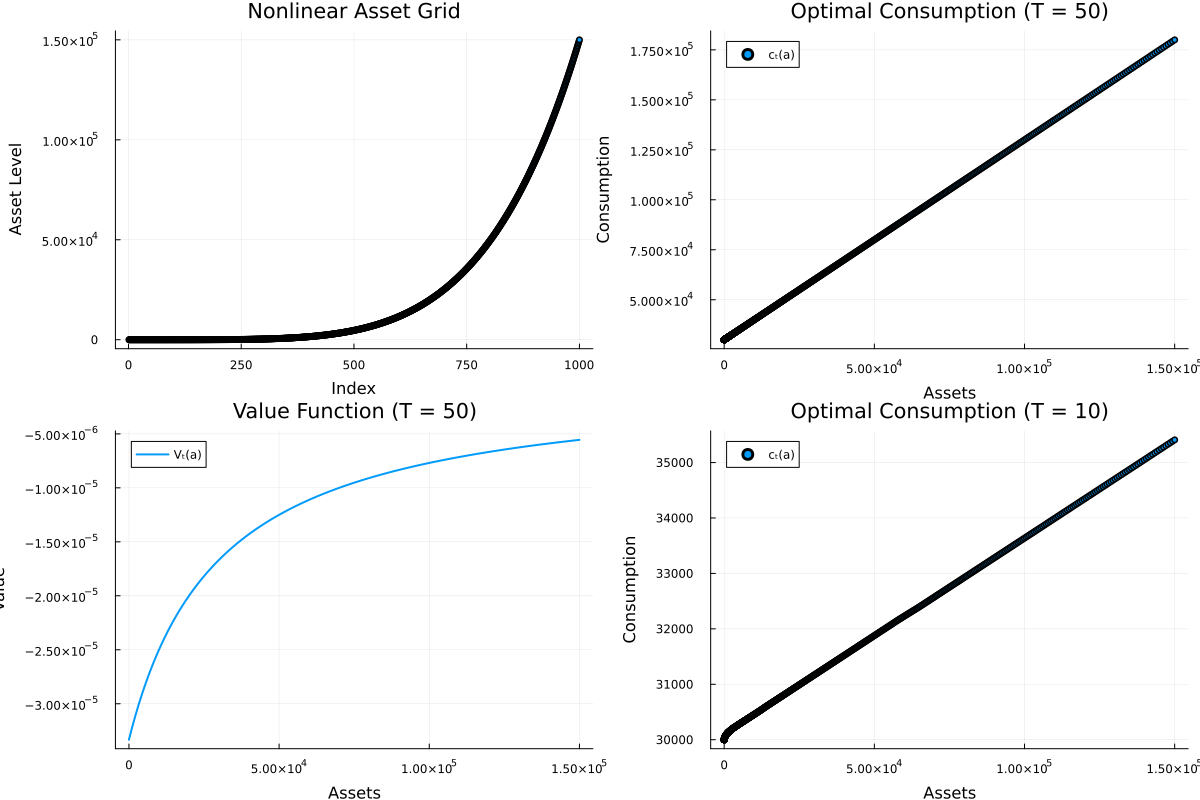

In [5]:
# ----------------------------------------
# Visualization of Model Structure and Solution
# ----------------------------------------

# 1. Plot the nonlinear asset grid to inspect density and shape
p1 = scatter(model.a_grid,
    xlabel = "Index",
    ylabel = "Asset Level",
    title = "Nonlinear Asset Grid",
    legend = false,
    markersize = 3)

# 2. Plot optimal consumption policy at terminal period (T = 50)
p2 = scatter(model.a_grid, model.sol_c[50, :],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = 50)",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = 50)
p3 = plot(model.a_grid, model.sol_V[50, :],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = 50)",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (T = 10)
p4 = scatter(model.a_grid, model.sol_c[10, :],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = 10)",
    label = "cₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p2, p3, p4, layout = (2, 2), size = (1200, 800))

###  Counterfactual Comparisons: Average Consumption Over Time

This part compares the **baseline consumption path** with four counterfactual scenarios in a finite-horizon consumption-saving model:

Each subplot highlights how different income and wealth profiles shape consumption smoothing behavior over time.

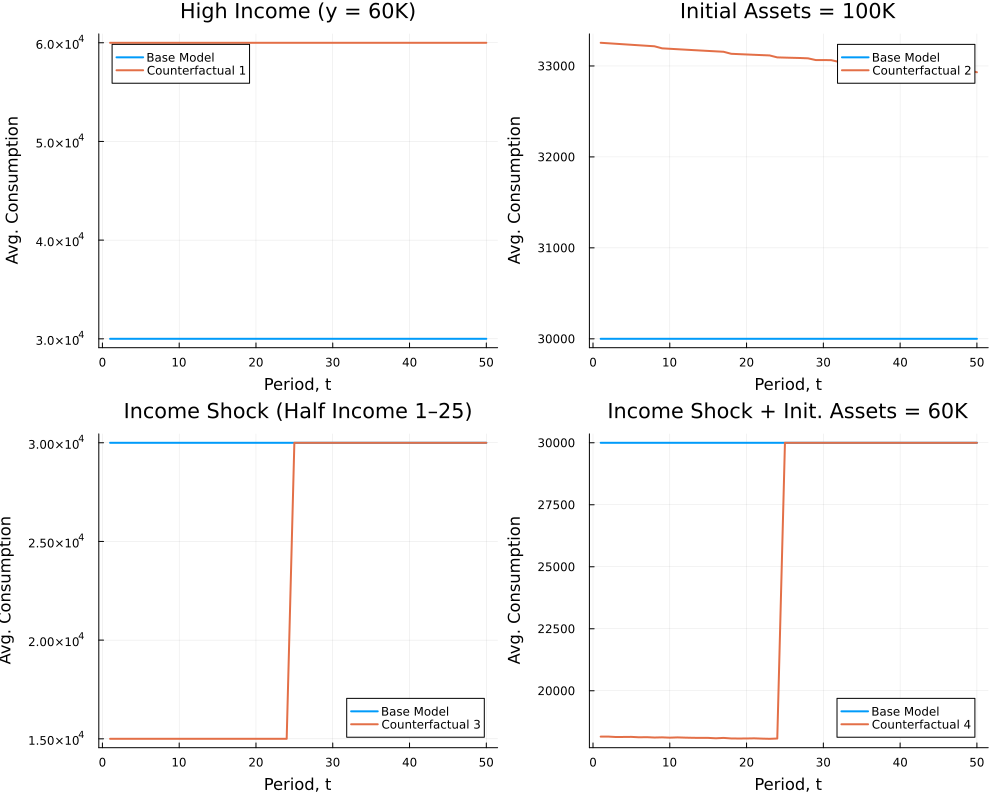

In [6]:
# Time grid
t_grid = 1:model.simT

# --- Subplot 1: Base vs Counterfactual 1 (High Income)
p1 = plot(t_grid, avg_c, label="Base Model", lw=2, title="High Income (y = 60K)")
plot!(p1, t_grid, avg_c1, label="Counterfactual 1", lw=2)
xlabel!(p1, "Period, t")
ylabel!(p1, "Avg. Consumption")

# --- Subplot 2: Base vs Counterfactual 2 (Initial Assets = 100K)
p2 = plot(t_grid, avg_c, label="Base Model", lw=2, title="Initial Assets = 100K")
plot!(p2, t_grid, avg_c2, label="Counterfactual 2", lw=2)
xlabel!(p2, "Period, t")
ylabel!(p2, "Avg. Consumption")

# --- Subplot 3: Base vs Counterfactual 3 (Income Shock)
p3 = plot(t_grid, avg_c, label="Base Model", lw=2, title="Income Shock (Half Income 1–25)")
plot!(p3, t_grid, avg_c3, label="Counterfactual 3", lw=2)
xlabel!(p3, "Period, t")
ylabel!(p3, "Avg. Consumption")

# --- Subplot 4: Base vs Counterfactual 4 (Income Shock + High Assets)
p4 = plot(t_grid, avg_c, label="Base Model", lw=2, title="Income Shock + Init. Assets = 60K")
plot!(p4, t_grid, avg_c4, label="Counterfactual 4", lw=2)
xlabel!(p4, "Period, t")
ylabel!(p4, "Avg. Consumption")

# --- Combine in a 2x2 grid
plot(p1, p2, p3, p4, layout=(2,2), size=(1000,800))

###  Counterfactual Comparisons: Average Assets Over Time

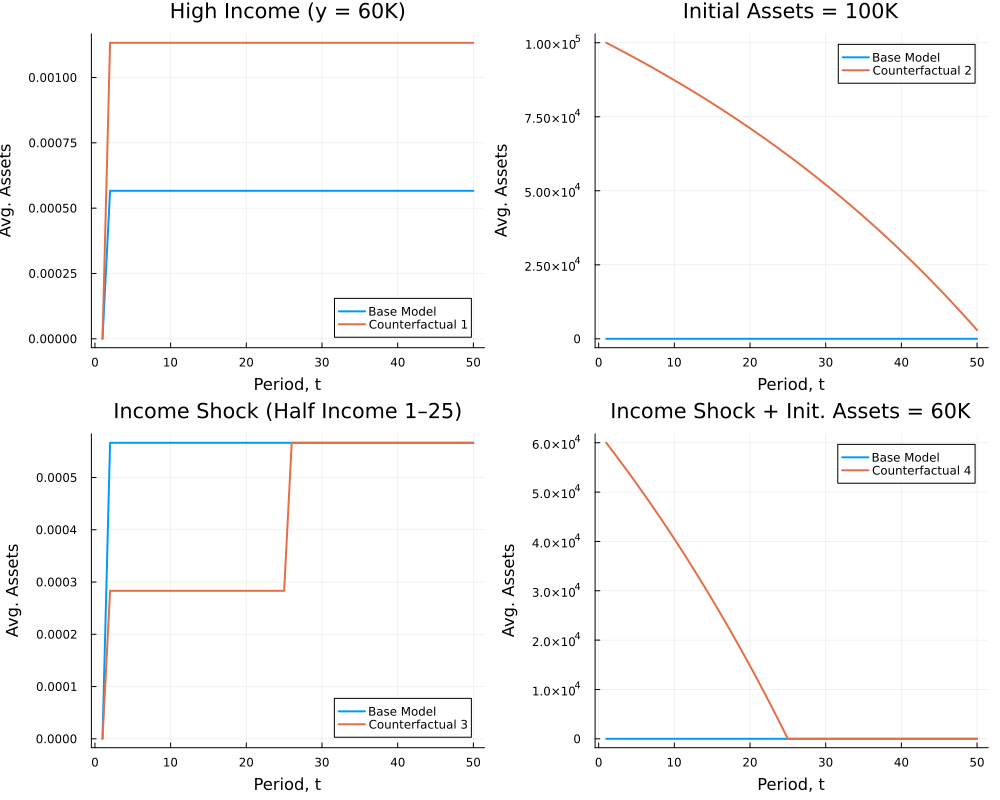

In [7]:
# Time grid
t_grid = 1:model.simT

# --- Subplot 1: Base vs Counterfactual 1 (High Income)
p1 = plot(t_grid, avg_a, label="Base Model", lw=2, title="High Income (y = 60K)")
plot!(p1, t_grid, avg_a1, label="Counterfactual 1", lw=2)
xlabel!(p1, "Period, t")
ylabel!(p1, "Avg. Assets")

# --- Subplot 2: Base vs Counterfactual 2 (Initial Assets = 100K)
p2 = plot(t_grid, avg_a, label="Base Model", lw=2, title="Initial Assets = 100K")
plot!(p2, t_grid, avg_a2, label="Counterfactual 2", lw=2)
xlabel!(p2, "Period, t")
ylabel!(p2, "Avg. Assets")

# --- Subplot 3: Base vs Counterfactual 3 (Income Shock)
p3 = plot(t_grid, avg_a, label="Base Model", lw=2, title="Income Shock (Half Income 1–25)")
plot!(p3, t_grid, avg_a3, label="Counterfactual 3", lw=2)
xlabel!(p3, "Period, t")
ylabel!(p3, "Avg. Assets")

# --- Subplot 4: Base vs Counterfactual 4 (Income Shock + High Assets)
p4 = plot(t_grid, avg_a, label="Base Model", lw=2, title="Income Shock + Init. Assets = 60K")
plot!(p4, t_grid, avg_a4, label="Counterfactual 4", lw=2)
xlabel!(p4, "Period, t")
ylabel!(p4, "Avg. Assets")

# --- Combine all in 2x2 layout
plot(p1, p2, p3, p4, layout=(2,2), size=(1000,800))